# Introduction: Dream Recommendation System
Project Members: Kazuki Shin, Ken Miyaki, Miao Li, Bhaswar Sarkar, Albert Nathan, Mark Villa 

In this notebook, we will build a dream recommendation system based on simple principle: user like a dream will like simlilar dreams. In order to create this representation of similar dreams, we'll use the concept of neural network entity embeddings, mapping each dream to a X-number vector.

The idea of entity embeddings is to map high-dimensional categorical variables to a low-dimensional learned representation that places similar entities closer together in the embedding space. If we were to one-hot-encode the dreams (another representation of categorical data) we would have a 1M+ dimension vector for each dream, with a single 1 indicating the dream. In a one-hot encoding, similar dreams would not be "closer" to one another. By training a neural network to learn entity embeddings, we not only get a reduced dimension representation of the dreams, we also get a representation that keeps similar dreams closer to each other. Therefore, the key approach for a recommendation system is to create entity embeddings of all the dreams, and then for any dream, find the closest other dreams in the embedding space.

#### Hypothesis:
1. Playing enjoyable Dreams is an on-ramp for deeper and longer engagement with the game.
2. People have personal preferences, and the process of finding a matching set of likeable Dreams has friction in actions such as typing text into the search UI and scrolling through random lists.
3. A Dream recommendation system can reduce this friction, and get players in front of enjoyable gaming experiences much sooner, thereby increasing the likelihood that they will stay engaged longer with the game.

#### Work:
1. Using data from Dreams about Dreams, players, and their interactions, create a model which reflects how much users ‘enjoyed’ each of the Dreams that they interacted with.
2. Create an algorithm (SVD, DNN, or otherwise), which can learn from the input data and respective extracted features to recommend a Dream to a player in some sortable scored manor.
3. Validate that the recommended Dreams are ‘good’ recommendations
4. Characterize the recommendation system’s overall accuracy on its predictive capabilities (e.g., MSE)
5. Create a Dreams recommendation network service which can work on the existing datasets, and allow for MM and others to evaluate the worth of this system over other techniques (such as SVD by Alex Evans or t-SNE)

#### Target phases:
1. For existing users, and existing Dreams in the system, recommend a set of Dreams for a person to play (that they haven’t already played); the goal of this is to try to extend existing user’s engagement with the game and to prevent them from churning.
2. For new users, and existing Dreams in the system, recommend a set of Dreams for the person to play; the goal of this is to try to decrease bounce rate, and increase the favorability of their initial impression of the game by having them play through delightful Dream content (e.g., Hug Me)
3. For new Dreams which don’t yet have any substantial play, attempt to link the characteristics/attributes of that Dream with known other characteristics/attributes (e.g., author, text tags, shared objects used, etc….) and recommend those new Dreams alongside existing Dreams such that we don’t end up with a reinforcing loop where only the existing Dreams are recommended, played, and thus more heavily weighted for subsequent recommendations.

#### Measures:
1. Did the person play the recommended Dream for at least the average play duration for that Dream?
2. Did the person explicitly “like” the recommended Dream?
3. Did the person go back and play the same Dream again?
4. For people who engage with the recommended Dreams and end up playing them, do they stay engaged with the game for a longer period of time before churning?  Do they go on to Create Mode and become Dream creators as a result of their longer retention?

We start by targeting phase 1 – existing users, existing Dreams, a set of prioritized recommendations

# Approach
To create entity embeddings, we need to build an embedding neural network and train it on a supervised machine learning task that will result in similar dreams having closer representations in embedding space. The parameters of the neural network - the weights - are the embeddings, and so during training, these numbers are adjusted to minimize the loss on the prediction problem. In other words, the network tries to accurately complete the task by changing the representations of the dreams
Load in data and clean Prepare data for supervised machine learning task Build the entity embedding neural network Train the neural network on prediction task. Extract embeddings and find most similar dreams. Visualize the embeddings using dimension reduction techniques

# Preprocessing
Creating 2 types of data frames: One for catalog m and another for catalog o and d. M type dream is playable dream while o and d type are both building blocks to create dreams.

In [1]:
from __future__ import print_function, division
from builtins import range, input
import re, itertools, math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam
from keras.initializers import he_normal

from dutils import restore_index,dream_id_to_idx,dream_idx_to_id,user_id_to_idx,user_idx_to_id,dream_id_to_title,save_index
from dutils import save_df, restore_df

Using TensorFlow backend.


In [14]:
dream2title= {}

users_m= []
dreams_m = []
ratings_m = []
seen_m = {}

user2idx_m = {}
idx2user_m = {}
dream2idx_m = {}
idx2dream_m = {}


# parses through db to extract ratings
# fills in the user, dream, and rating array
def extract_ratings():
  # grep titles
  db = open("db2", "r")
  i = 0
  # ["dreams.oc7a627a020523e.title",1546560897406,"Handy Graph Display"]
  p1 = re.compile('dreams\.([^\.]+)\.title[^,]+,[^,]+,[^\"]?\"([^\"]+)\"')
  #   p2 = re.compile('graph\.([^\.]+)\.like\.([^\"]+)"')
  p_d1 = re.compile('u\S{14}.like.d\S{14}')
  p_d2 = re.compile('graph.d\S*.was_played_by.u\S*total')
  p_o1 = re.compile('u\S{14}.like.o\S{14}')
  p_o2 = re.compile('graph.o\S*.was_played_by.u\S*total')
  p_m1 = re.compile('u\S{14}.like.m\S{14}')
  p_m2 = re.compile('graph.m\S*.was_played_by.u\S*total')

  for line in db:
      if i > 0 and i % 5000000 == 0:
          print("parsing {}M lines.".format(int(i/1000000)))
      
      match = p1.findall(line)
      if len(match) > 0:
          dream2title[match[0][0]] = match[0][1]
    
      #print("parsing db_playedby for m")
      match = p_m2.findall(line)
      if len(match) > 0:
          x = match[0]
          user_dream = x[:x.find('"')]
          not_user_dream = x[x.find('"'):]
          dream_id = user_dream.split('.')[1]
          user_id = user_dream.split('.')[3]
          play_cnt = not_user_dream.split('"')[3]
          play_cnt = play_cnt[1:-1]
          play_dur = not_user_dream.split('"')[7]
          play_dur = play_dur[1:-1]

          # placing caps on the stats
          cnt = int(play_cnt)
          if cnt > 50:
            cnt = 50

          dur = int(play_dur)
          if dur > 3600:
            dur = 3600

          if cnt and dur is not 0:
            val = math.log(cnt,3) + math.log(dur,10)
          elif dur is not 0:
            val = math.log(dur,10)
          elif cnt is not 0:
            val = math.log(cnt,3)
          else:
            val = 0
            
          key = user_id+":"+dream_id
          seen_m[key] = val
        
      #print("parsing db_like for m")
      match = p_m1.findall(line)
      if len(match) > 0:
          x = match[0]
          user_id = x.split('.')[0]
          dream_id = x.split('.')[2]
          users_m.append(user_id)
          dreams_m.append(dream_id)
          
          key = user_id+":"+dream_id
          val = 3
          if key in seen_m:
            val += seen_m[key]
            seen_m[key] = -1
          ratings_m.append(val)
        
      i+=1
    
  for k, v in seen_m.items():
    if v is not -1:
      k_arr = k.split(":")
      user_id = k_arr[0]
      dream_id = k_arr[1]
      users_m.append(user_id)
      dreams_m.append(dream_id)
      ratings_m.append(v)
      seen_m[k] = -1

  db.close()    

extract_ratings()

parsing 5M lines.
parsing 10M lines.
parsing 15M lines.
parsing 20M lines.
parsing 25M lines.
parsing 30M lines.
parsing 35M lines.
parsing 40M lines.
parsing 45M lines.
parsing 50M lines.
parsing 55M lines.
parsing 60M lines.
parsing 65M lines.
parsing 70M lines.
parsing 75M lines.
parsing 80M lines.


# Converting to Pandas dataframe

In [15]:
# This function produce sequencial index for user id and dream id
def convert_id_to_idx_m(df):
  # create a mapping for user ids
  unique_user_ids = set(df.user_id.values) 
  idx = 0
  for user_id in unique_user_ids:
    user2idx_m[user_id] = idx
    idx2user_m[idx] = user_id
    idx += 1
  df['user_idx'] = df.apply(lambda row: user2idx_m[row.user_id], axis=1)
  
  # create a mapping for dream ids
  unique_dream_ids = set(df.dream_id.values)
  idx = 0
  for dream_id in unique_dream_ids:
    dream2idx_m[dream_id] = idx
    idx2dream_m[idx] = dream_id
    idx += 1
  df['dream_idx'] = df.apply(lambda row: dream2idx_m[row.dream_id], axis=1)

# creating dataframe for ratings matrix
print("creating m dataframe")
data_m = {'user_id':users_m, 'dream_id':dreams_m, 'rating':ratings_m}
df_m = pd.DataFrame(data_m)
convert_id_to_idx_m(df_m)

save_df(df_m)
print("Catalog m has sample size: "+str(len(df_m)))
save_index("m",user2idx_m, idx2user_m, dream2idx_m, idx2dream_m, dream2title)

creating m dataframe
name 'file_suffix' is not defined
name 'file_suffix' is not defined
name 'file_suffix' is not defined
name 'file_suffix' is not defined
name 'file_suffix' is not defined
Catalog m has sample size: 5437760
remove file ./data/dream2title_m
remove file ./data/idx2dream_m
remove file ./data/idx2user_m
remove file ./data/dream2idx_m
remove file ./data/user2idx_m


# Variational Autoencoder Models

Sparse Matrix

In [2]:
df_m = restore_df()

N = df_m.user_idx.max() + 1 # number of users
M = df_m.dream_idx.max() + 1 # number of movies

# normalized data - rescale between 0 and 1
df_m['rating'] -= df_m['rating'].min()
df_m['rating'] /= df_m['rating'].max()

# split into train and test
df = shuffle(df_m)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

A = lil_matrix((N, M))
print("Calling: update_train")
count = 0
def update_train(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/cutoff))

  i = int(row.user_idx)
  j = int(row.dream_idx)
  A[i,j] = row.rating
df_train.apply(update_train, axis=1)

# mask, to tell us which entries exist and which do not
A = A.tocsr()
mask = (A > 0)
save_npz("Atrain.npz", A)

# test ratings dictionary
A_test = lil_matrix((N, M))
print("Calling: update_test")
count = 0
def update_test(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/len(df_test)))

  i = int(row.user_idx)
  j = int(row.dream_idx)
  A_test[i,j] = row.rating
df_test.apply(update_test, axis=1)
A_test = A_test.tocsr()
mask_test = (A_test > 0)
save_npz("Atest.npz", A_test)

Calling: update_train
processed: 0.023
processed: 0.046
processed: 0.069
processed: 0.092
processed: 0.115
processed: 0.138
processed: 0.161
processed: 0.184
processed: 0.207
processed: 0.230
processed: 0.253
processed: 0.276
processed: 0.299
processed: 0.322
processed: 0.345
processed: 0.368
processed: 0.391
processed: 0.414
processed: 0.437
processed: 0.460
processed: 0.483
processed: 0.506
processed: 0.529
processed: 0.552
processed: 0.575
processed: 0.598
processed: 0.621
processed: 0.644
processed: 0.667
processed: 0.690
processed: 0.713
processed: 0.736
processed: 0.759
processed: 0.782
processed: 0.805
processed: 0.828
processed: 0.851
processed: 0.874
processed: 0.897
processed: 0.919
processed: 0.942
processed: 0.965
processed: 0.988
Calling: update_test
processed: 0.092
processed: 0.184
processed: 0.276
processed: 0.368
processed: 0.460
processed: 0.552
processed: 0.644
processed: 0.736
processed: 0.828
processed: 0.919


Autoencoder code

In [2]:
from __future__ import print_function, division
from builtins import range, input
import re, itertools, math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam
from keras.initializers import he_normal

N: 107004 M: 6778
N // batch_size: 835
mu: 0.26946366272552985
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/30
836/836 [==============================] - 158s 189ms/step - loss: 130.5406 - custom_loss: 0.0276 - val_loss: 13.3907 - val_custom_loss: 0.0272
Epoch 2/30
836/836 [==============================] - 155s 186ms/step - loss: 11.5077 - custom_loss: 0.0269 - val_loss: 9.8216 - val_custom_loss: 0.0267
Epoch 3/30
836/836 [==============================] - 155s 186ms/step - loss: 8.4755 - custom_loss: 0.0264 - val_loss: 7.2689 - val_custom_loss: 0.0263
Epoch 4/30
836/836 [==============================] - 156s 187ms/step - loss: 6.3070 - custom_loss: 0.0261 - val_loss: 5.4447 - val_custom_loss: 0.0260
Epoch 5/30
836/836 [==============================] - 154s 184ms/step - loss: 4.7559 - custom_loss: 0.0258 - val_loss: 4.1381 - val_custom

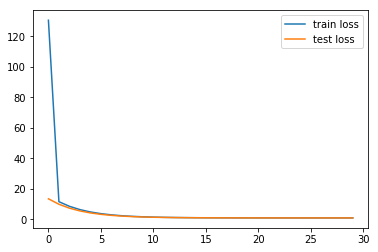

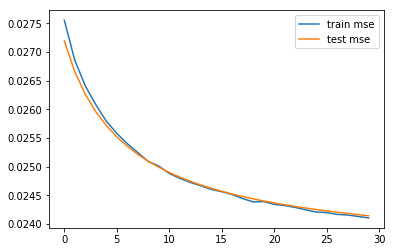

In [ ]:
# config
batch_size = 128
epochs = 30
reg = 0.01
he_normal(seed=None)
# reg = 0

A = load_npz("Atrain.npz")
A_test = load_npz("Atest.npz")
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

# make copies since we will shuffle
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)

# build the model - just a 1 hidden layer autoencoder
i = Input(shape=(M,))
x = Dropout(0.7)(i)
x = Dense(1000, activation='relu', kernel_regularizer=l1(reg))(x)
x = Dense(M, kernel_regularizer=l2(reg))(x)

def custom_loss(y_true, y_pred):
  mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
  diff = y_pred - y_true
  sqdiff = diff * diff * mask
  sse = K.sum(K.sum(sqdiff))
  n = K.sum(K.sum(mask))
  return sse / n

def generator(A, M):
  while True:
    A, M = shuffle(A, M)
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      a = a - mu * m # must keep zeros at zero!
      noisy = a # no noise
      yield noisy, a

def test_generator(A, M, A_test, M_test):
  # assumes A and A_test are in corresponding order
  # both of size N x M
  while True:
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      at = A_test[i*batch_size:upper].toarray()
      mt = M_test[i*batch_size:upper].toarray()
      a = a - mu * m
      at = at - mu * mt
      yield a, at

model = Model(i, x)
model.compile(
  loss=custom_loss,
  optimizer=SGD(lr=0.001, momentum=0.9),
  # optimizer=Adam(lr=0.005),
  metrics=[custom_loss],
)

r = model.fit_generator(
  generator(A, mask),
  validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
  epochs=epochs,
  steps_per_epoch=A.shape[0] // batch_size + 1,
  validation_steps=A_test.shape[0] // batch_size + 1,
)
print(r.history.keys())

# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()


In [ ]:
from keras.models import load_model
#model.save('model_autorec_v2.h5')
model.save_weights('model_autorec.h5')
# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [9]:
# predicting top 10 recommendations for user idx 3 using catalog o and d model
from scipy.sparse import lil_matrix
from keras.models import model_from_json

user_idx = 789

# Model reconstruction from JSON file
with open('model_architecture.json', 'r') as f:
    model = model_from_json(f.read())
# Load weights into the new model
model.load_weights('model_autorec.h5')

# model = load_model("model_autorec.h5")
user2idx_m, idx2user_m, dream2idx_m, idx2dream_m, dream2title_m = restore_index("m")
N, M = load_npz("Atrain.npz").shape

dream_len = len(idx2dream_m)
dream_idx = np.arange(0,dream_len)
# P = lil_matrix((N, M))

user_input = np.full((1,dream_len), user_idx)
result = model.predict(user_input)

print("Predict results:")
# print(np.ndarray.flatten(result).shape)
# print(result.shape)

# Sort result indexes from smallest to largest
sorted_result = np.argsort(np.ndarray.flatten(result))
print(sorted_result[-50:])
print("User Id: "+str(idx2user_m[user_idx]))
print("Sorted list:")
[idx2dream_m[idx] for idx in sorted_result[-10:]]

Predict results:
[1722 2574  184 4041 6601 1119 1382 4121 3273 6704 4206 1166 5716 6286
 2585 2102 1426 3719 1632 3420 4489  234  156 2324 6753  454 2737 4569
  241 4735 1349 2014 6096 1092 3123 5364  279 5424 1064 2782 5502 4458
 3073 1380 1475 5700 5106  970 3968 6454]
User Id: u9b728c9658a3a1
Sorted list:


['m2f987e8889c0dd',
 'm2a9c33703450e3',
 'ma72fcfa001979a',
 'm05700e3389c056',
 'm0dfcccb9594d5d',
 'm970ec2b7bbd3b2',
 'mbbcb973bada1f5',
 'md12d8654acee64',
 'm1b2df9488bdd8c',
 'mcab1b13f71df1e']

# Finding Similar Dreams
We've trained the model and extracted the embeddings. Now that we have the embeddings, we can use them to visulize dreams that our model has learned are most similar to a given dream.

## Function to Find Most Similar Entities
The function below takes in either a user or dream, a set of embeddings, and returns the n most similar items to the query. It does this by computing the dot product between the query and embeddings. Because we normalized the embeddings, the dot product represents the cosine similarity between two vectors. This is a measure of similarity that does not depend on the magnitude of the vector in contrast to the Euclidean distance. (The Euclidean distance would be another valid metric of similary to use to compare the embeddings.)

Once we have the dot products, we can sort the results to find the closest entities in the embedding space. With cosine similarity, higher numbers indicate entities that are closer together, with -1 the furthest apart and +1 closest together.

[ 5591  5298 14154  8244  9956  5809  7615  2368 10995 10977]
['A Haunted Entrance(da14f57b1cfa05b)', 'Traverse Town First District (WIP)(d34ccb292679bbe)', 'Not so Chill Island(d00f134245c7f5f)', 'Purgatory - work in progress(dedfa7862516949)', 'A simple platformer(d8660ecb44c4363)', 'Hex(deadd9e2a50e015)', 'School(d8723fdf31026cd)', 'Spirit of the Holidays(d8e87270ade05f0)', 'Afternoon Dreaming(d9eadd13388e280)', '2(d597aa17be408e5)', 'Puzzle world(ddcb4fa4e02c818)', 'Blank Canvas 3(deb7f8b0ba468ba)', 'Ai movement(de1bec3941d20ce)', 'Cutscene(d33e477202bb0e5)', 'A Simple Tropical Island Scene(d9823e3d973d420)']
[-2.1215186, -1.7550032, -1.6440483, -1.4966751, -1.4852248, 4.358141, 4.385614, 4.4230537, 4.4230876, 4.437207, 4.440693, 4.5919895, 4.599721, 4.784124, 4.8038464]


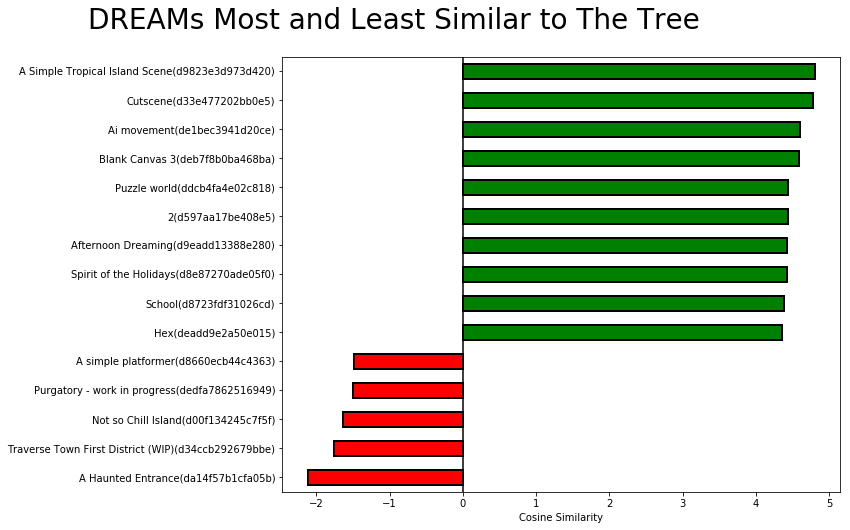

In [11]:
import matplotlib.pyplot as plt

dream = model.get_layer('dream_embedding')
dream_weights = dream.get_weights()[0]
dream_lengths = np.linalg.norm(dream_weights, axis=1)
# normalized_dreams = (dream_weights.T / dream_lengths).T

def similar_dreams(dream, n = 10):
    # Check to make sure `dream` is in index
    try:
        # Calculate dot product between dream and all others
#         dists = np.dot(normalized_dreams, normalized_dreams[dream_id_to_idx(dream)])
        dists = np.dot(dream_weights, dream_weights[dream_id_to_idx(dream)])
    except KeyError:
        print(f'{dream} Not Found.')
        return
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Find furthest and closest items
    furthest = sorted_dists[:(n // 2)]
    closest = sorted_dists[-n-1: len(dists) - 1]
    items = ["{}({})".format(dream_id_to_title(dream_idx_to_id(c)),dream_idx_to_id(c)) for c in furthest]
    items.extend("{}({})".format(dream_id_to_title(dream_idx_to_id(c)),dream_idx_to_id(c)) for c in closest)
    print(closest)
    print(items)
    # Find furthest and closets distances
    distances = [dists[c] for c in furthest]
    distances.extend(dists[c] for c in closest)
    print(distances)
    colors = ['r' for _ in range(n //2)]
    colors.extend('g' for _ in range(n))
    data = pd.DataFrame({'distance': distances}, index = items)
    # Horizontal bar chart
    data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
    plt.xlabel('Cosine Similarity');
    plt.axvline(x = 0, color = 'k');
    # Formatting for italicized title
    name_str = 'DREAMs Most and Least Similar to {}'.format(dream_id_to_title(dream))
    plt.title(name_str, x = 0.2, size = 28, y = 1.05)
    
# similar_dreams('m8da2b59fe1990a')
similar_dreams('d963f8745f97a62')
# import ipdb; ipdb.set_trace()

# Visualizations
One of the most interesting parts about embeddings is that we can use them to visualize the distance between dreams. First we have to take the embeddings from 20 dimensions down to either 3 or 2. We can do this using pca, tsne, or umap. We'll try both tsne and umap for comparison. TSNE takes much longer and is designed to retain local structure within the data. UMAP is generally quicker and is designed for a balance between local and global structure in the embedding.

# Manifold Embeddings
TSNE: t-Stochastic Distributed Neighbors Embedding, and UMAP: Uniform Manifold Approximation and Projection, are both methods that use the idea of a manifold to map vecotrs to a lower dimensional embedded space. Therefore, we are taking the one-hot vector of dreams, embedding them to 20 dimensions with the neural network, and then embedding them down to 2 dimensions with a manifold. The primary idea behind dimension reduction with a manifold is that there is a lower dimensional representation of the vectors that can still capture the variation between different groups. We want the embeddings to represent similar entities close to one another but in fewer dimensions that allow us to visualize the entities.

In [12]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

In [14]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [16]:
dream_weights_class = extract_weights('dream_embedding', model)
dream_weights_class.shape

(16760, 10)

In [17]:
dream_r = reduce_dim(dream_weights_class, components = 2, method = 'tsne')
dream_r.shape

(16760, 2)

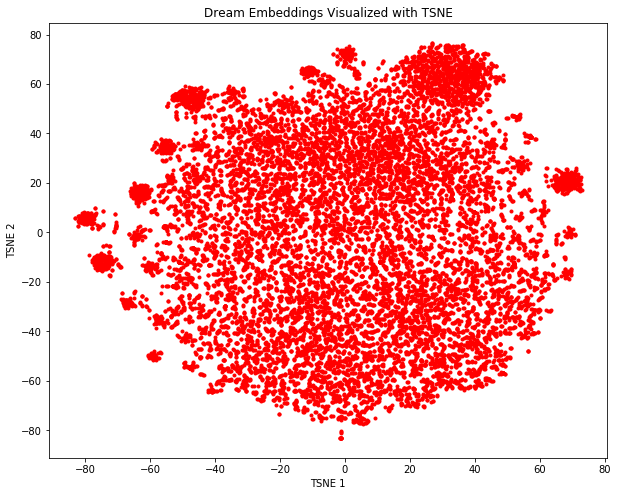

In [19]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(dream_r[:, 0], dream_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Dream Embeddings Visualized with TSNE');

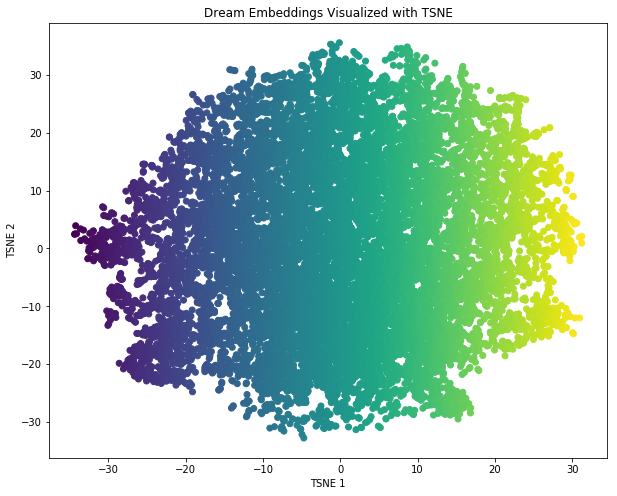

In [33]:
plt.figure(figsize = (10, 8))
plt.scatter(dream_r[:, 0], dream_r[:, 1], c=dream_r[:, 0])
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Dream Embeddings Visualized with TSNE');

In [22]:
dream_r = reduce_dim(dream_weights_class, components = 3, method = 'tsne')
dream_r.shape

(16760, 3)

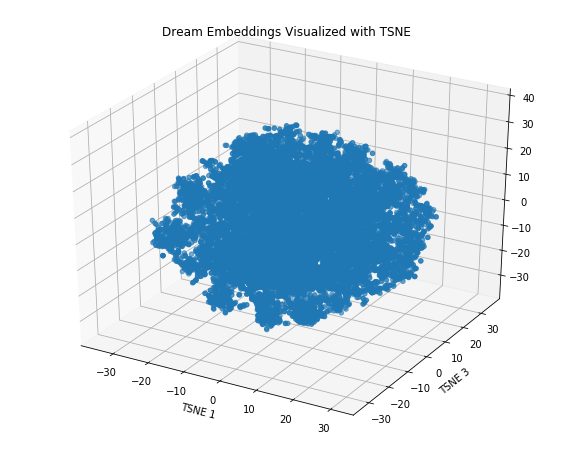

In [30]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize = (10, 8))
ax = plt.axes(projection='3d')
ax.scatter(dream_r[:, 0], dream_r[:, 1],dream_r[:, 2], 'gray')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.ylabel('TSNE 3')
plt.title('Dream Embeddings Visualized with TSNE');
# TODO: Better visual https://medium.com/@vegi/visualizing-higher-dimensional-data-using-t-sne-on-tensorboard-7dbf22682cf2